In [1]:
!pip install livelossplot

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.1.0


In [5]:
train_data_dir="/kaggle/input/courserafacemoreco/train/"
validation_data_dir="/kaggle/input/courserafacemoreco/test/"

In [6]:
num_classes = 0
for expression in os.listdir(train_data_dir):
    print(str(len(os.listdir(train_data_dir+expression)))+" "+expression +" images")
    num_classes += 1
print(num_classes)

7214 happy images
4830 sad images
4965 neutral images
3171 surprise images
3995 angry images
5


In [7]:
img_rows, img_cols = 224, 224
# img_size = 48 # old
img_size = 224 
batch_size = 64 # or 32



# datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True) # old
datagen_train = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = datagen_train.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows,img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# datagen_validation = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True) # old
datagen_validation = ImageDataGenerator(rescale=1. / 255,horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows,img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 24175 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


In [8]:
print(train_generator.n)
print(validation_generator.n)

24175
6043


In [9]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

17227776/17225924 [==============================] - 0s 0us/step


In [10]:
base_model.trainable = True

In [11]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  87


In [12]:
# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [13]:
top_model = base_model.output
global_average_layer = GlobalAveragePooling2D()
top_model = global_average_layer(top_model)
print(top_model.shape)

(None, 1024)


In [ ]:
"""
top_model = Dense(1024)(top_model)
top_model = BatchNormalization()(top_model)
top_model = LeakyReLU()(top_model)
top_model = Dropout(0.25)(top_model)

top_model = Dense(1024)(top_model)
top_model = BatchNormalization()(top_model)
top_model = LeakyReLU()(top_model)
top_model = Dropout(0.25)(top_model)

top_model = Dense(512)(top_model)
top_model = BatchNormalization()(top_model)
top_model = LeakyReLU()(top_model)
top_model = Dropout(0.25)(top_model)
"""

In [15]:
top_model = Dense(num_classes, activation='softmax')(top_model)

#model = tf.keras.Sequential([base_model,global_average_layer,top_model])
model = Model(inputs=base_model.input, outputs=top_model)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [17]:
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss_categ = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss_categ, metrics=['accuracy'])

In [18]:
epochs = 200

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              min_lr=0.00001,
                              verbose=1, #me
                              mode='auto')


checkpoint = ModelCheckpoint("CNNEmoDetMobileNetV1FineTune_weights.h5",
                             monitor='val_loss',
                             save_best_only=True,#me
                             save_weights_only=True,
                             mode='min',
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=14,
                          verbose=1,
                          restore_best_weights=True)


callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr, earlystop]

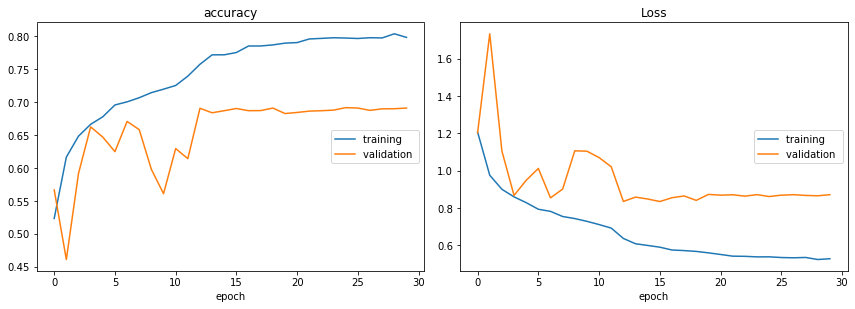

accuracy
	training         	 (min:    0.523, max:    0.804, cur:    0.798)
	validation       	 (min:    0.461, max:    0.691, cur:    0.691)
Loss
	training         	 (min:    0.523, max:    1.207, cur:    0.527)
	validation       	 (min:    0.834, max:    1.734, cur:    0.871)

Epoch 00030: val_loss did not improve from 0.83428
Restoring model weights from the end of the best epoch.
377/377 [==============================] - 313s 829ms/step - loss: 0.5274 - accuracy: 0.7981 - val_loss: 0.8710 - val_accuracy: 0.6908
Epoch 00030: early stopping


In [19]:
history = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks)

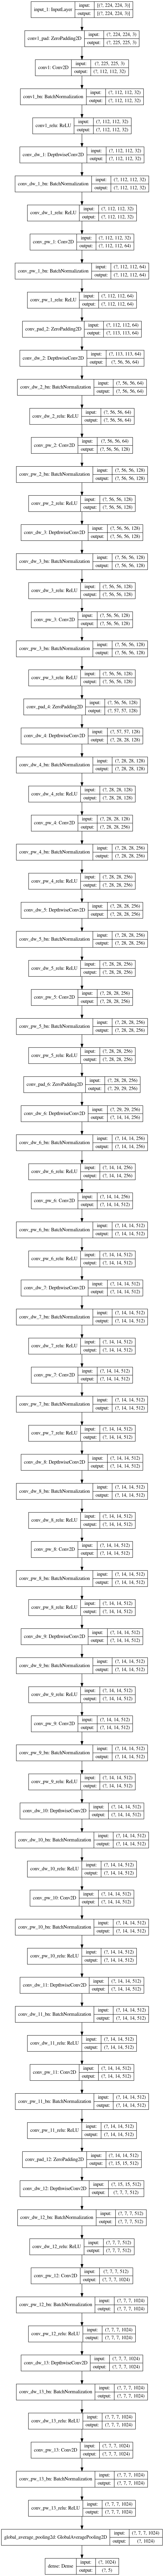

In [20]:
plot_model(model, to_file='CNNEmoDetMobileNetV1FineTune.png', show_shapes=True)

In [21]:
model.save("CNNEmoDetMobileNetV1FineTune.h5")

In [22]:
model_json = model.to_json()
with open("JCNNEmoDetMobileNetV1FineTune.json","w") as json_file:
    json_file.write(model_json)

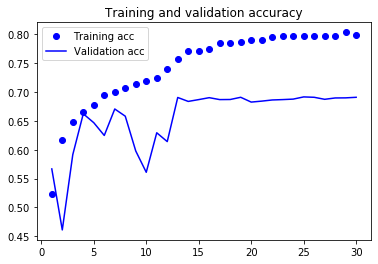

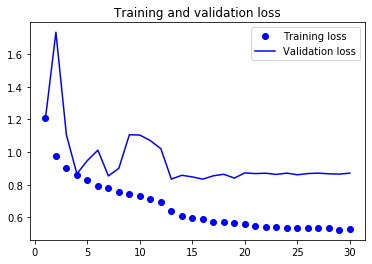

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()